In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib import gridspec

import numpy as np
import scipy.sparse as sp
import numpy.linalg as la

In [2]:
# https://www.opengl.org/sdk/docs/man2/xhtml/gluPerspective.xml
# https://unspecified.wordpress.com/2012/06/21/calculating-the-gluperspective-matrix-and-other-opengl-matrix-maths/
def perspective_matrix(fovY, aspect, near, far):
    #print fovY
    #print aspect
    f = 1.0 / np.tan (fovY / 2.0)
    p_matrix = np.matrix([[f/aspect, 0.0, 0.0, 0.0],
                          [0.0, f, 0.0, 0.0],
                          [0.0, 0.0, (far+near)/(near-far), (2.0*far*near)/(near-far)], 
                          [0.0, 0.0, -1.0, 0.0]])
    return p_matrix

# axes to camera space
def arcball_matrix(camForward, camUp):
    z = -camForward
    z = z / la.norm(z) # forward
    y = camUp # up
    x = np.cross(y, z) # right
    y = np.cross(z, x)
    x = x / la.norm(x)
    y = y / la.norm(y)
    return np.matrix([[x[0], x[1], x[2], 0.0], 
                      [y[0], y[1], y[2], 0.0],
                      [z[0], z[1], z[2], 0.0],
                      [0.0, 0.0, 0.0, 1.0]])

def homogeneous_times(matrix, vec3):
    homogeneous_point = np.matrix([vec3[0], vec3[1], vec3[2], 1.0])
    vec4 = matrix * np.transpose(homogeneous_point)
    homogeneous_return = np.array([vec4[0]/vec4[3], vec4[1]/vec4[3], vec4[2]/vec4[3]])
    homogeneous_return = np.reshape(homogeneous_return, (1, 3))
    return np.array([homogeneous_return[0][0], homogeneous_return[0][1], homogeneous_return[0][2]])

# Conversion from world space to camera screen space
def world_to_screen(point, cam, forward, up, fovY, aspect):
    #print "cam = ", cam
    #print "forward = ", forward
    #print "up = ", up
    
    proj = perspective_matrix(fovY, aspect, 0.1, 100.0)
    #print "proj"
    #print proj
    arcball = arcball_matrix(forward, up)
    #print "arcball"
    #print arcball

    look = cam + forward
    eye_space_point = np.array([0.0, 0.0, -1.0]) + homogeneous_times(arcball, point - look)
    #print "eye_space_point ", eye_space_point

    image_space_point = homogeneous_times(proj, eye_space_point)
    #print "image_space_point ", image_space_point
    return np.array([image_space_point[0], image_space_point[1]])

In [3]:
# Apex shot (from Unity: z,x,-y)
# Apex - new camera position: (-39.6, 0.8, -92.7) orientation (0.0, 180.0, 0.0) forward (0.0, 0.0, -1.0) up (0.0, 1.0, 0.0)

# camera specs (position, forward, up, fov)
C = np.array([-92.9,-39.6,-0.8])
fwd = np.array([-1.0,0.0,0.0])
u = np.array([0.0,0.0,-1.0])
asp = 16.0/9.0
fvY = 0.8726646

# scene specs
PA = np.array([-98.2,-40.6,-1.6])     # person A position
PB = np.array([-98.2,-38.6,-1.6])     # person B position

SA = world_to_screen(PA, C, fwd, u, fvY, asp) # 0.220588 0.314124
SB = world_to_screen(PB, C, fwd, u, fvY, asp) # -0.220588 0.314124

print "SA ", SA
print "SB ", SB

SA  [ 0.22760098  0.32369917]
SB  [-0.22760098  0.32369917]


In [4]:
def add_relative_to_current_source_file_path_to_sys_path(relpath):
    import os, sys, inspect
    path = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile(inspect.currentframe()))[0],relpath)))
    if path not in sys.path:
        sys.path.insert(0,path)

add_relative_to_current_source_file_path_to_sys_path("../../shims/toric")   

import toric
import toric.samples
import toric.shims

#
# Helper functions for the toric libary
#

def vector3_to_str(v):
    return "(%.2f, %.2f, %.2f)" % (v.x(), v.y(), v.z())

def quaternion_to_str(q):
    return "(w,x,y,z): (%.2f, %.2f, %.2f, %.2f)" % (q.w(), q.x(), q.y(), q.z())

def vector3_to_np3(v):
    return np.array([v.x(),v.y(),v.z()])

def np3_to_vector3(v):
    return toric.Vector3(v[0],v[1],v[2])

def slerp(p0, p1, t):
        omega = np.arccos(np.dot(p0/np.linalg.norm(p0), p1/np.linalg.norm(p1)))
        so = np.sin(omega)
        return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1
    
def fovX_from_fovY(fovY, aspect):
    tanY = np.tan(fovY / 2.0)
    tanX = tanY * aspect;
    fovX = np.arctan(tanX)
    return fovX
    
def drawSetup(fudgeX=8, fudgeY_pos=4,fudgeY_neg=8):
    pylab.rcParams['figure.figsize'] = 8, 8

    plt.axes().set_aspect('equal')
    fig = plt.gcf()
    
    # Set up plot size
    plt.axes().set_xlim((np.min([PA_1.x(), PB_1.x()])-fudgeX,np.max([PA_1.x(), PB_1.x()])+fudgeX))
    plt.axes().set_ylim((np.min([PA_1.y(), PB_1.y()])-fudgeY_neg,np.max([PA_1.y(), PB_1.y()])+fudgeY_pos))

    # Draw People Positions
    plt.scatter([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()],c="red",linewidths=0)
    line_AB = plt.Line2D([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()], c="black",alpha=0.3)
    fig.gca().add_artist(line_AB)

    # Draw Circles    
    circle_PA_1=plt.Circle((PA_1.x(),PA_1.y()),min_dist,color='g',alpha=0.5)
    circle_PB_1=plt.Circle((PB_1.x(),PB_1.y()),min_dist,color='g',alpha=0.5)
    
    fig.gca().add_artist(circle_PA_1)
    fig.gca().add_artist(circle_PB_1)

    plt.annotate(s="A", xy=(PA_1.x(),PA_1.y()),xytext=(3,4),textcoords="offset points")
    plt.annotate(s="B", xy=(PB_1.x(),PB_1.y()),xytext=(3,4),textcoords="offset points")
    
    # Draw Camera positions - including toric interpolation
    plt.scatter([C_1.x(), C_2.x()],[C_1.y(), C_2.y()],c="blue",linewidths=0)
    plt.annotate(s="C1", xy=(C_1.x(), C_1.y()),xytext=(3,4),textcoords="offset points")
    plt.annotate(s="C2", xy=(C_2.x(), C_2.y()),xytext=(3,4),textcoords="offset points")
    plt.plot(sigma[:,0],sigma[:,1])

In [35]:
# graph in screen space
def drawScreenSetup():
    pylab.rcParams['figure.figsize'] = 9, 16

    plt.axes().set_aspect('equal')
    fig = plt.gcf()
    
    # Set up plot size
    plt.axes().set_xlim(-1, 1)
    plt.axes().set_ylim(-1, 1)
    
    # Draw rule of thirds
    line_l = plt.Line2D([-0.33, -0.33],[-1, 1], c="black",alpha=0.3)
    line_r = plt.Line2D([0.33, 0.33],[-1, 1], c="black",alpha=0.3)
    line_b = plt.Line2D([-1, 1],[-0.33, -0.33], c="black",alpha=0.3)
    line_t = plt.Line2D([-1, 1],[0.33, 0.33], c="black",alpha=0.3)
    fig.gca().add_artist(line_l)
    fig.gca().add_artist(line_r)
    fig.gca().add_artist(line_b)
    fig.gca().add_artist(line_t)
    
    # Draw new interpolated positions
    #plt.scatter(SA_x_lin,SA_y_lin,cmap='copper',linewidths=0)
    #plt.scatter(SB_x_lin,SB_y_lin,cmap='copper',linewidths=0)
    
    # Draw A screen positions
    plt.scatter([SA_1.x(), SA_2.x()],[SA_1.y(), SA_2.y()],c="red",linewidths=0)
    line_A = plt.Line2D([SA_1.x(), SA_2.x()],[SA_1.y(), SA_2.y()], c="black",alpha=0.3)
    plt.annotate(s="SA1", xy=(SA_1.x(), SA_1.y()),xytext=(3,4),textcoords="offset points")
    plt.annotate(s="SA2", xy=(SA_2.x(), SA_2.y()),xytext=(3,4),textcoords="offset points")
    fig.gca().add_artist(line_A)
    
    # Draw B screen positions
    plt.scatter([SB_1.x(), SB_2.x()],[SB_1.y(), SB_2.y()],c="red",linewidths=0)
    line_B = plt.Line2D([SB_1.x(), SB_2.x()],[SB_1.y(), SB_2.y()], c="black",alpha=0.3)
    plt.annotate(s="SB1", xy=(SB_1.x(), SB_1.y()),xytext=(3,4),textcoords="offset points")
    plt.annotate(s="SB2", xy=(SB_2.x(), SB_2.y()),xytext=(3,4),textcoords="offset points")
    fig.gca().add_artist(line_B)

def drawNewScreenSetup():
    # Draw new interpolated positions
    plt.scatter(SA_x_lin_new,SA_y_lin_new,cmap='copper',linewidths=0)
    plt.scatter(SB_x_lin_new,SB_y_lin_new,cmap='copper',linewidths=0)
    
    # Draw new A screen positions
    plt.scatter([SA_1_new.x(), SA_2_new.x()],[SA_1_new.y(), SA_2_new.y()],c="green",linewidths=0)
    plt.annotate(s="SA1_new", xy=(SA_1_new.x(), SA_1_new.y()),xytext=(3,-10),textcoords="offset points")
    plt.annotate(s="SA2_new", xy=(SA_2_new.x(), SA_2_new.y()),xytext=(3,-10),textcoords="offset points")
    
    # Draw new B screen positions
    plt.scatter([SB_1_new.x(), SB_2_new.x()],[SB_1_new.y(), SB_2_new.y()],c="green",linewidths=0)
    plt.annotate(s="SB1_new", xy=(SB_1_new.x(), SB_1_new.y()),xytext=(3,-10),textcoords="offset points")
    plt.annotate(s="SB2_new", xy=(SB_2_new.x(), SB_2_new.y()),xytext=(3,-10),textcoords="offset points")

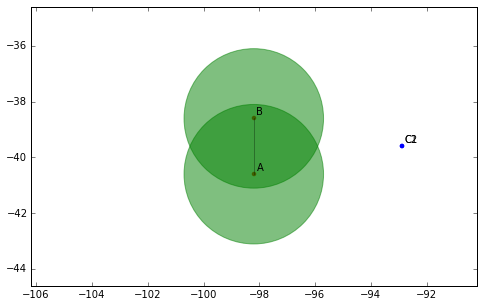

In [36]:
# YAW
C_1 = toric.Vector3(C[0], C[1], C[2])
C_2 = toric.Vector3(C[0], C[1], C[2])

min_dist = 2.5
PA_1 = toric.Vector3(PA[0], PA[1], PA[2])
PB_1 = toric.Vector3(PB[0], PB[1], PB[2])

SA_1 = toric.Vector2(SA[0], SA[1])
SB_1 = toric.Vector2(SB[0], SB[1])

# toric position trajectory
C_1t = toric.Toric3_FromWorldPosition(C_1, PA_1, PB_1)
C_2t = toric.Toric3_FromWorldPosition(C_2, PA_1, PB_1)

interp = toric.ToricInterpolator(PA_1, PB_1, C_1t, C_2t)

t = np.linspace(0,1)
sigma = np.array([toric.Toric3_ToWorldPosition(interp.interpolate(a),PA_1,PB_1).np() for a in t])

drawSetup(fudgeY_neg=4)

[ 0.22760098  0.32369917]
[-0.22760098  0.32369917]
re:  [ 0.22760098  0.32369917]
re:  [-0.22760098  0.32369917]


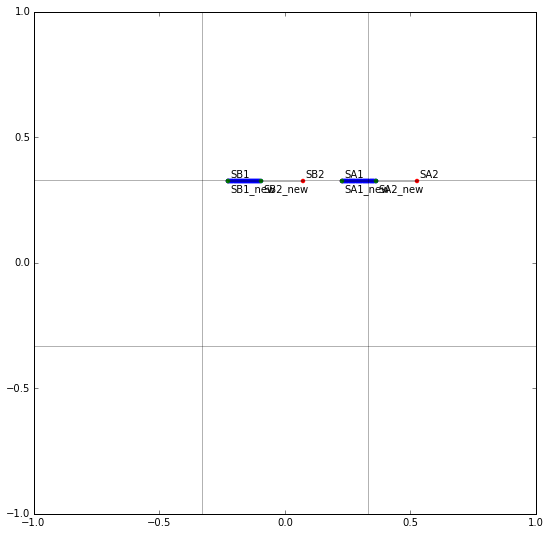

In [38]:
# YAW
SA_2 = toric.Vector2(SA[0] + 0.3, SA[1])
SB_2 = toric.Vector2(SB[0] + 0.3, SB[1])

# interpolated screen space positions
SA_x_lin = np.linspace(SA_1.x(),SA_2.x())
SA_y_lin = np.linspace(SA_1.y(),SA_2.y())

SB_x_lin = np.linspace(SB_1.x(),SB_2.x())
SB_y_lin = np.linspace(SB_1.y(),SB_2.y())

fvX = fovX_from_fovY(fvY, asp)
orientations = np.array([toric.Toric3_ComputeOrientationForTwoTargets(np3_to_vector3(sigma[t_c]), toric.Vector2(SA_x_lin[t_c], SA_y_lin[t_c]), toric.Vector2(SB_x_lin[t_c], SB_y_lin[t_c]), PA_1, PB_1, toric.RadianPi(fvX), toric.RadianPi(fvY)) for t_c in range(0, len(t))])
orient_vectors = np.array([v.yAxis().np() for v in orientations])
up_vectors = np.array([v.zAxis().np() for v in orientations])

# Calculated screen space from orientation
SA_path = np.array([world_to_screen(PA, sigma[t_c], orient_vectors[t_c], up_vectors[t_c], fvY, asp) for t_c in range(0, len(t))])
SB_path = np.array([world_to_screen(PB, sigma[t_c], orient_vectors[t_c], up_vectors[t_c], fvY, asp) for t_c in range(0, len(t))])

SA_x_lin_new = SA_path[:,0]
SA_y_lin_new = SA_path[:,1]

SB_x_lin_new = SB_path[:,0]
SB_y_lin_new = SB_path[:,1]

# Recalculate screen space from calculated orientation
SA_recalc = world_to_screen(PA, C, fwd, u, fvY, asp)
SB_recalc = world_to_screen(PB, C, fwd, u, fvY, asp)

SA_test = SA_path[0]
SB_test = SB_path[0]
last = len(t)-1
SA_test2 = SA_path[last]
SB_test2 = SB_path[last]

print SA_test
print SB_test
print "re: ", SA_recalc
print "re: ", SB_recalc

SA_1_new = toric.Vector2(SA_test[0], SA_test[1])
SA_2_new = toric.Vector2(SA_test2[0], SA_test2[1])

SB_1_new = toric.Vector2(SB_test[0], SB_test[1])
SB_2_new = toric.Vector2(SB_test2[0], SB_test2[1])

drawScreenSetup()
drawNewScreenSetup()

[ 0.22760098  0.32369917]
[-0.22760098  0.32369917]
re:  [ 0.22760098  0.32369917]
re:  [-0.22760098  0.32369917]


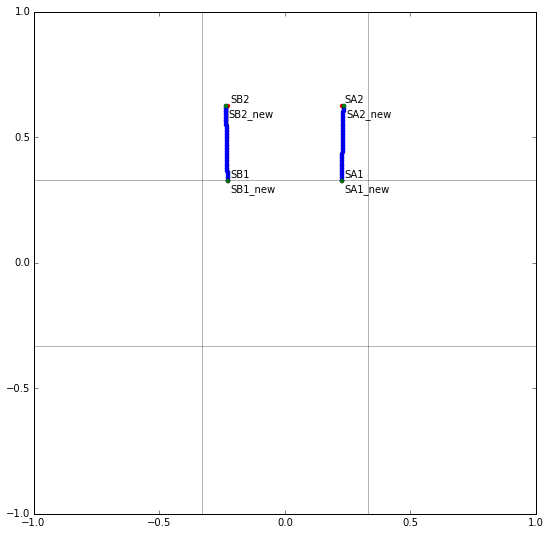

In [41]:
# PITCH
SA_2 = toric.Vector2(SA[0], SA[1] + 0.3)
SB_2 = toric.Vector2(SB[0], SB[1] + 0.3)

# interpolated screen space positions
SA_x_lin = np.linspace(SA_1.x(),SA_2.x())
SA_y_lin = np.linspace(SA_1.y(),SA_2.y())

SB_x_lin = np.linspace(SB_1.x(),SB_2.x())
SB_y_lin = np.linspace(SB_1.y(),SB_2.y())

fvX = fovX_from_fovY(fvY, asp)
orientations = np.array([toric.Toric3_ComputeOrientationForTwoTargets(np3_to_vector3(sigma[t_c]), toric.Vector2(SA_x_lin[t_c], SA_y_lin[t_c]), toric.Vector2(SB_x_lin[t_c], SB_y_lin[t_c]), PA_1, PB_1, toric.RadianPi(fvX), toric.RadianPi(fvY)) for t_c in range(0, len(t))])
orient_vectors = np.array([v.yAxis().np() for v in orientations])
up_vectors = np.array([v.zAxis().np() for v in orientations])

# Calculated screen space from orientation
SA_path = np.array([world_to_screen(PA, sigma[t_c], orient_vectors[t_c], up_vectors[t_c], fvY, asp) for t_c in range(0, len(t))])
SB_path = np.array([world_to_screen(PB, sigma[t_c], orient_vectors[t_c], up_vectors[t_c], fvY, asp) for t_c in range(0, len(t))])

SA_x_lin_new = SA_path[:,0]
SA_y_lin_new = SA_path[:,1]

SB_x_lin_new = SB_path[:,0]
SB_y_lin_new = SB_path[:,1]

# Recalculate screen space from calculated orientation
SA_recalc = world_to_screen(PA, C, fwd, u, fvY, asp)
SB_recalc = world_to_screen(PB, C, fwd, u, fvY, asp)

SA_test = SA_path[0]
SB_test = SB_path[0]
last = len(t)-1
SA_test2 = SA_path[last]
SB_test2 = SB_path[last]

print SA_test
print SB_test
print "re: ", SA_recalc
print "re: ", SB_recalc

SA_1_new = toric.Vector2(SA_test[0], SA_test[1])
SA_2_new = toric.Vector2(SA_test2[0], SA_test2[1])

SB_1_new = toric.Vector2(SB_test[0], SB_test[1])
SB_2_new = toric.Vector2(SB_test2[0], SB_test2[1])

drawScreenSetup()
drawNewScreenSetup() 

0.8726646
1.77777777778
[ 0.22760098  0.32369917]
[-0.22760098  0.32369917]
re:  [ 0.22760098  0.32369917]
re:  [-0.22760098  0.32369917]


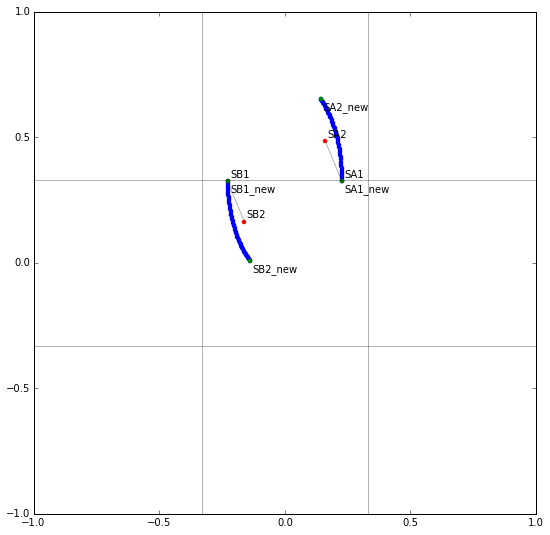

In [20]:
# ROLL
dist = la.norm(SA - SB)
center = np.array([SA[0] - dist / 2, SA[1]])
SA_2 = toric.Vector2(center[0] + (dist/2) * np.cos(0.785398), center[1] + (dist/2) * np.sin(0.785398))
SB_2 = toric.Vector2(center[0] - (dist/2) * np.cos(0.785398), center[1] - (dist/2) * np.sin(0.785398))

# interpolated screen space positions
SA_x_lin = np.linspace(SA_1.x(),SA_2.x())
SA_y_lin = np.linspace(SA_1.y(),SA_2.y())

SB_x_lin = np.linspace(SB_1.x(),SB_2.x())
SB_y_lin = np.linspace(SB_1.y(),SB_2.y())

print fvY
print asp
fvX = fovX_from_fovY(fvY, asp)
orientations = np.array([toric.Toric3_ComputeOrientationForTwoTargets(np3_to_vector3(sigma[t_c]), toric.Vector2(SA_x_lin[t_c], SA_y_lin[t_c]), toric.Vector2(SB_x_lin[t_c], SB_y_lin[t_c]), PA_1, PB_1, toric.RadianPi(fvX), toric.RadianPi(fvY)) for t_c in range(0, len(t))])
orient_vectors = np.array([v.yAxis().np() for v in orientations])
up_vectors = np.array([v.zAxis().np() for v in orientations])

# Calculated screen space from orientation
SA_path = np.array([world_to_screen(PA, sigma[t_c], orient_vectors[t_c], up_vectors[t_c], fvY, asp) for t_c in range(0, len(t))])
SB_path = np.array([world_to_screen(PB, sigma[t_c], orient_vectors[t_c], up_vectors[t_c], fvY, asp) for t_c in range(0, len(t))])

SA_x_lin_new = SA_path[:,0]
SA_y_lin_new = SA_path[:,1]

SB_x_lin_new = SB_path[:,0]
SB_y_lin_new = SB_path[:,1]

# Recalculate screen space from calculated orientation
SA_recalc = world_to_screen(PA, C, fwd, u, fvY, asp)
SB_recalc = world_to_screen(PB, C, fwd, u, fvY, asp)

SA_test = SA_path[0]
SB_test = SB_path[0]
last = len(t)-1
SA_test2 = SA_path[last]
SB_test2 = SB_path[last]

print SA_test
print SB_test
print "re: ", SA_recalc
print "re: ", SB_recalc

SA_1_new = toric.Vector2(SA_test[0], SA_test[1])
SA_2_new = toric.Vector2(SA_test2[0], SA_test2[1])

SB_1_new = toric.Vector2(SB_test[0], SB_test[1])
SB_2_new = toric.Vector2(SB_test2[0], SB_test2[1])

drawScreenSetup()
drawNewScreenSetup()

(-92.90, -39.60, -0.80)
(a = 21.14°, t = 159°, p = 8.58°)
(a = 21.14°, t = 60°, p = 8.58°)
(-96.06, -36.86, -1.28)


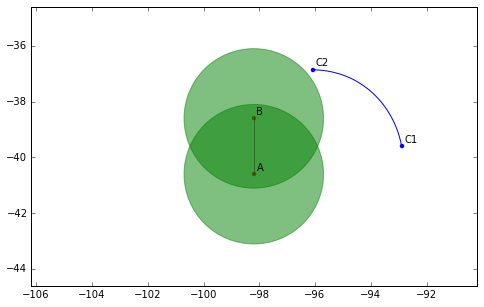

In [32]:
# TORIC
C_1 = toric.Vector3(C[0], C[1], C[2])
print C_1

min_dist = 2.5
PA_1 = toric.Vector3(PA[0], PA[1], PA[2])
PB_1 = toric.Vector3(PB[0], PB[1], PB[2])

SA_1 = toric.Vector2(SA[0], SA[1])
SB_1 = toric.Vector2(SB[0], SB[1])

# toric position trajectory
C_1t = toric.Toric3_FromWorldPosition(C_1, PA_1, PB_1)
C_2t = toric.Toric3(C_1t)
new_theta = toric.Radian2Pi(1.0472) # 60 degrees
C_2t.setTheta(new_theta)

print C_1t
print C_2t

C_2 = toric.Toric3_ToWorldPosition(C_2t, PA_1, PB_1)
print C_2

interp = toric.ToricInterpolator(PA_1, PB_1, C_1t, C_2t)

t = np.linspace(0,1)
sigma = np.array([toric.Toric3_ToWorldPosition(interp.interpolate(a),PA_1,PB_1).np() for a in t])

drawSetup(fudgeY_neg=4)

[ 0.22760098  0.32369917]
[-0.22760098  0.32369917]
re:  [ 0.22760098  0.32369917]
re:  [-0.22760098  0.32369917]


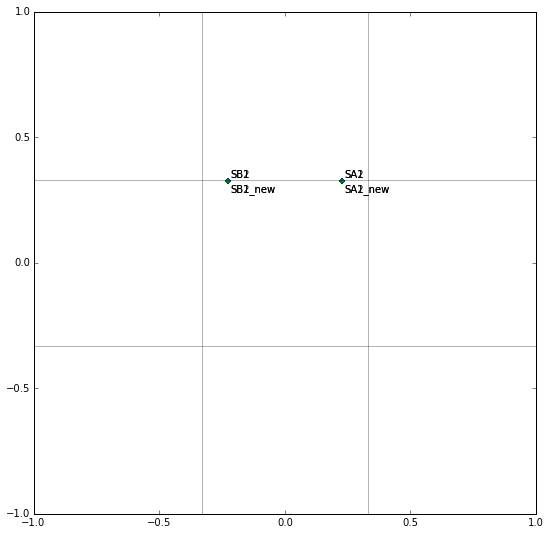

In [45]:
SA_2 = SA_1
SB_2 = SB_1

# interpolated screen space positions
SA_x_lin = np.linspace(SA_1.x(),SA_2.x())
SA_y_lin = np.linspace(SA_1.y(),SA_2.y())

SB_x_lin = np.linspace(SB_1.x(),SB_2.x())
SB_y_lin = np.linspace(SB_1.y(),SB_2.y())

fvX = fovX_from_fovY(fvY, asp)
orientations = np.array([toric.Toric3_ComputeOrientationForTwoTargets(np3_to_vector3(sigma[t_c]), toric.Vector2(SA_x_lin[t_c], SA_y_lin[t_c]), toric.Vector2(SB_x_lin[t_c], SB_y_lin[t_c]), PA_1, PB_1, toric.RadianPi(fvX), toric.RadianPi(fvY)) for t_c in range(0, len(t))])
orient_vectors = np.array([v.yAxis().np() for v in orientations])
up_vectors = np.array([v.zAxis().np() for v in orientations])

# Calculated screen space from orientation
SA_path = np.array([world_to_screen(PA, sigma[t_c], orient_vectors[t_c], up_vectors[t_c], fvY, asp) for t_c in range(0, len(t))])
SB_path = np.array([world_to_screen(PB, sigma[t_c], orient_vectors[t_c], up_vectors[t_c], fvY, asp) for t_c in range(0, len(t))])

SA_x_lin_new = SA_path[:,0]
SA_y_lin_new = SA_path[:,1]

SB_x_lin_new = SB_path[:,0]
SB_y_lin_new = SB_path[:,1]

# Recalculate screen space from calculated orientation
SA_recalc = world_to_screen(PA, C, fwd, u, fvY, asp)
SB_recalc = world_to_screen(PB, C, fwd, u, fvY, asp)

SA_test = SA_path[0]
SB_test = SB_path[0]
last = len(t)-1
SA_test2 = SA_path[last]
SB_test2 = SB_path[last]

print SA_test
print SB_test
print "re: ", SA_recalc
print "re: ", SB_recalc

SA_1_new = toric.Vector2(SA_test[0], SA_test[1])
SA_2_new = toric.Vector2(SA_test2[0], SA_test2[1])

SB_1_new = toric.Vector2(SB_test[0], SB_test[1])
SB_2_new = toric.Vector2(SB_test2[0], SB_test2[1])

drawScreenSetup()
drawNewScreenSetup()

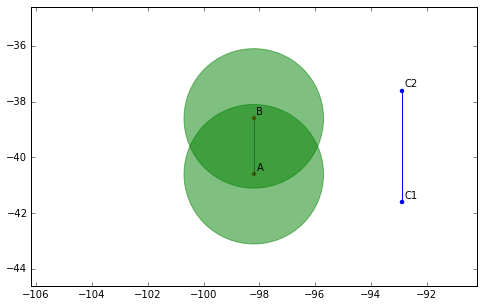

In [58]:
# Straight line
min_dist = 2.5
PA_1 = toric.Vector3(PA[0], PA[1], PA[2])
PB_1 = toric.Vector3(PB[0], PB[1], PB[2])
dist = la.norm(PA - PB)

C_1 = toric.Vector3(C[0], C[1] - dist, C[2])
C_2 = toric.Vector3(C[0], C[1] + dist, C[2])

SA_1 = toric.Vector2(SA[0], SA[1])
SB_1 = toric.Vector2(SB[0], SB[1])

# linearly interpolated position trajectory
C_x_lin = np.linspace(C_1.x(),C_2.x())
C_y_lin = np.linspace(C_1.y(),C_2.y())
C_z_lin = np.linspace(C_1.z(),C_2.z())

t = np.linspace(0,1)
sigma = np.c_[C_x_lin, C_y_lin, C_z_lin]

drawSetup(fudgeY_neg=4)

[ 0.20051448  0.32369917]
[-0.20051448  0.32369917]
re:  [ 0.22760098  0.32369917]
re:  [-0.22760098  0.32369917]


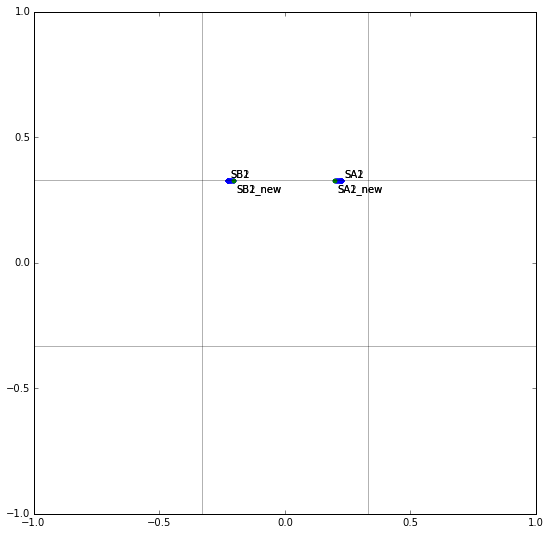

In [59]:
SA_2 = SA_1
SB_2 = SB_1

# interpolated screen space positions
SA_x_lin = np.linspace(SA_1.x(),SA_2.x())
SA_y_lin = np.linspace(SA_1.y(),SA_2.y())

SB_x_lin = np.linspace(SB_1.x(),SB_2.x())
SB_y_lin = np.linspace(SB_1.y(),SB_2.y())

fvX = fovX_from_fovY(fvY, asp)
orientations = np.array([toric.Toric3_ComputeOrientationForTwoTargets(np3_to_vector3(sigma[t_c]), toric.Vector2(SA_x_lin[t_c], SA_y_lin[t_c]), toric.Vector2(SB_x_lin[t_c], SB_y_lin[t_c]), PA_1, PB_1, toric.RadianPi(fvX), toric.RadianPi(fvY)) for t_c in range(0, len(t))])
orient_vectors = np.array([v.yAxis().np() for v in orientations])
up_vectors = np.array([v.zAxis().np() for v in orientations])

# Calculated screen space from orientation
SA_path = np.array([world_to_screen(PA, sigma[t_c], orient_vectors[t_c], up_vectors[t_c], fvY, asp) for t_c in range(0, len(t))])
SB_path = np.array([world_to_screen(PB, sigma[t_c], orient_vectors[t_c], up_vectors[t_c], fvY, asp) for t_c in range(0, len(t))])

SA_x_lin_new = SA_path[:,0]
SA_y_lin_new = SA_path[:,1]

SB_x_lin_new = SB_path[:,0]
SB_y_lin_new = SB_path[:,1]

# Recalculate screen space from calculated orientation
SA_recalc = world_to_screen(PA, C, fwd, u, fvY, asp)
SB_recalc = world_to_screen(PB, C, fwd, u, fvY, asp)

SA_test = SA_path[0]
SB_test = SB_path[0]
last = len(t)-1
SA_test2 = SA_path[last]
SB_test2 = SB_path[last]

print SA_test
print SB_test
print "re: ", SA_recalc
print "re: ", SB_recalc

SA_1_new = toric.Vector2(SA_test[0], SA_test[1])
SA_2_new = toric.Vector2(SA_test2[0], SA_test2[1])

SB_1_new = toric.Vector2(SB_test[0], SB_test[1])
SB_2_new = toric.Vector2(SB_test2[0], SB_test2[1])

drawScreenSetup()
drawNewScreenSetup()